In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut

In [141]:
df_jinhyeok = pd.read_csv("./data/진혁_데이터프레임.csv")
df_jinhyeok.rename(columns={"Unnamed: 0":"행정구역","Unnamed: 1":"계절","Unnamed: 2":"연도"},inplace=True)

month_spring = ["_3","_4","_5"]
month_summer = ["_5","_6","_7","_8"]
month_fall = ["_8","_9","_10","_11"]
month_winter = ["_8","_9","_10","_11","_12","_1","_2"]

season = ["spring", "summer", "fall", "winter"]

for i in range(len(season)) : 
    globals()["df_"+season[i]] = df_jinhyeok[df_jinhyeok["계절"]==season[i]]
    globals()["df_"+season[i]] = globals()["df_"+season[i]].groupby(["행정구역","계절","연도"]).mean()

In [142]:
df_jinhyeok[df_jinhyeok["계절"]=="summer"]

,행정구역,계절,연도,평균기온(°C)_1월,최고기온(°C)_1월,최저기온(°C)_1월,월합강수량(00~24h만)(mm)_1월,합계 일사량(MJ/m2)_1월,평균기온(°C)_2월,최고기온(°C)_2월,...,최저기온(°C)_11월,월합강수량(00~24h만)(mm)_11월,합계 일사량(MJ/m2)_11월,평균기온(°C)_12월,최고기온(°C)_12월,최저기온(°C)_12월,월합강수량(00~24h만)(mm)_12월,합계 일사량(MJ/m2)_12월,면적 (ha),생산량 (톤)
374,강원도,summer,2000,-2.90,8.50,-16.00,48.10,152.990,-3.3,7.70,...,-8.40,30.20,231.670,-1.40,12.50,-14.90,16.90,234.16,7461.0,281280.0
375,강원도,summer,2001,-2.65,10.20,-15.00,52.20,202.280,-2.3,8.30,...,-7.90,25.00,262.150,-0.55,13.25,-12.90,24.10,248.43,7277.0,290571.0
376,강원도,summer,2002,1.40,13.20,-9.60,21.90,173.530,1.2,13.50,...,-4.20,56.00,301.480,2.00,16.10,-8.30,2.50,287.57,5645.0,215921.0
377,강원도,summer,2003,-0.30,10.70,-12.60,29.20,167.555,0.2,10.40,...,-6.90,51.50,229.380,0.40,14.80,-11.20,4.90,235.80,6284.0,238289.0
378,강원도,summer,2004,1.00,15.30,-8.80,33.70,176.490,0.6,12.40,...,-3.00,53.80,295.020,3.20,16.70,-6.60,6.40,294.42,5964.0,231642.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,충청북도,summer,2017,1.70,16.15,-13.90,33.30,275.670,5.2,21.65,...,-1.45,51.95,302.590,4.05,15.75,-8.70,4.00,272.30,0.0,0.0
744,충청북도,summer,2018,-0.40,14.30,-18.60,36.00,274.140,3.7,21.90,...,-2.80,86.40,280.285,2.80,14.30,-10.70,9.50,250.05,0.0,0.0
745,충청북도,summer,2019,6.85,17.85,-3.25,82.85,218.455,9.2,22.95,...,6.60,59.40,279.035,9.05,18.25,-0.80,24.30,189.37,0.0,0.0
746,충청북도,summer,2020,-1.90,13.90,-20.80,26.95,255.445,2.9,19.35,...,-3.75,89.50,266.970,1.30,13.40,-12.55,11.55,230.85,0.0,0.0


In [ ]:
# df=df[df['행정구역']=='강원도']
# df=pd.pivot_table(df, index=["일시", '행정구역'],aggfunc="mean")
# df=df.query('일시.str.contains("03|04|05")', engine='python')
# df=df.query('일시.str.contains("2000")', engine='python')

In [143]:
spr = "|".join(w for w in month_spring)

In [144]:
df_spring.columns[df_spring.columns.str.contains(spr+"|면적|생산")]

Index(['평균기온(°C)_3월', '최고기온(°C)_3월', '최저기온(°C)_3월', '월합강수량(00~24h만)(mm)_3월',
       '합계 일사량(MJ/m2)_3월', '평균기온(°C)_4월', '최고기온(°C)_4월', '최저기온(°C)_4월',
       '월합강수량(00~24h만)(mm)_4월', '합계 일사량(MJ/m2)_4월', '평균기온(°C)_5월',
       '최고기온(°C)_5월', '최저기온(°C)_5월', '월합강수량(00~24h만)(mm)_5월',
       '합계 일사량(MJ/m2)_5월', '면적 (ha)', '생산량 (톤)'],
      dtype='object')

In [145]:
for i in range(len(season)) : 
    globals()["month_str_"+season[i]] = "|".join(w for w in globals()["month_"+season[i]])
    globals()["col_of_"+season[i]] = globals()["df_"+season[i]].columns[globals()["df_"+season[i]].columns.str.contains(globals()["month_str_"+season[i]]+"|면적|생산")]

In [146]:
print(month_spring)
print(col_of_spring)

['_3', '_4', '_5']
Index(['평균기온(°C)_3월', '최고기온(°C)_3월', '최저기온(°C)_3월', '월합강수량(00~24h만)(mm)_3월',
       '합계 일사량(MJ/m2)_3월', '평균기온(°C)_4월', '최고기온(°C)_4월', '최저기온(°C)_4월',
       '월합강수량(00~24h만)(mm)_4월', '합계 일사량(MJ/m2)_4월', '평균기온(°C)_5월',
       '최고기온(°C)_5월', '최저기온(°C)_5월', '월합강수량(00~24h만)(mm)_5월',
       '합계 일사량(MJ/m2)_5월', '면적 (ha)', '생산량 (톤)'],
      dtype='object')


In [147]:
df_spring = df_spring[col_of_spring]
df_summer = df_summer[col_of_summer]
df_fall = df_fall[col_of_fall]
df_winter = df_winter[col_of_winter]

In [148]:
df_winter.dropna(how="any",inplace=True)
# df_winter

In [149]:
df_spring.fillna(0,inplace=True)
df_summer.fillna(0,inplace=True)
df_fall.fillna(0,inplace=True)

print(df_spring.info())
print(df_summer.info())
print(df_fall.info())


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 374 entries, ('강원도', 'spring', 2000) to ('충청북도', 'spring', 2021)
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   평균기온(°C)_3월            374 non-null    float64
 1   최고기온(°C)_3월            374 non-null    float64
 2   최저기온(°C)_3월            374 non-null    float64
 3   월합강수량(00~24h만)(mm)_3월  374 non-null    float64
 4   합계 일사량(MJ/m2)_3월       374 non-null    float64
 5   평균기온(°C)_4월            374 non-null    float64
 6   최고기온(°C)_4월            374 non-null    float64
 7   최저기온(°C)_4월            374 non-null    float64
 8   월합강수량(00~24h만)(mm)_4월  374 non-null    float64
 9   합계 일사량(MJ/m2)_4월       374 non-null    float64
 10  평균기온(°C)_5월            374 non-null    float64
 11  최고기온(°C)_5월            374 non-null    float64
 12  최저기온(°C)_5월            374 non-null    float64
 13  월합강수량(00~24h만)(mm)_5월  374 non-null    float64
 14  합계 일사량(MJ/m2)_5

In [150]:
print(df_winter.info())


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135 entries, ('강원도', 'winter', 2014) to ('충청북도', 'winter', 2021)
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   평균기온(°C)_1월             135 non-null    float64
 1   최고기온(°C)_1월             135 non-null    float64
 2   최저기온(°C)_1월             135 non-null    float64
 3   월합강수량(00~24h만)(mm)_1월   135 non-null    float64
 4   합계 일사량(MJ/m2)_1월        135 non-null    float64
 5   평균기온(°C)_2월             135 non-null    float64
 6   최고기온(°C)_2월             135 non-null    float64
 7   최저기온(°C)_2월             135 non-null    float64
 8   월합강수량(00~24h만)(mm)_2월   135 non-null    float64
 9   합계 일사량(MJ/m2)_2월        135 non-null    float64
 10  평균기온(°C)_8월             135 non-null    float64
 11  최고기온(°C)_8월             135 non-null    float64
 12  최저기온(°C)_8월             135 non-null    float64
 13  월합강수량(00~24h만)(mm)_8월   135 non-null    float64
 14 

In [151]:
df_spring[:30]

평균기온(°C)_3월  최고기온(°C)_3월  최저기온(°C)_3월  \
행정구역 계절     연도                                            
강원도  spring 2000         4.40        19.30        -8.60   
            2001         5.25        19.75        -8.60   
            2002         7.30        19.70        -7.30   
            2003         6.60        21.30        -6.00   
            2004         6.90        20.30        -4.90   
            2005         7.90        19.40        -3.70   
            2006         6.10        20.20        -6.80   
            2007         9.10        18.30        -2.50   
            2008         6.30        18.90        -4.80   
            2009         4.90        20.70        -8.90   
            2010         8.70        19.90        -2.90   
            2011         5.10        17.60        -5.10   
            2012         6.45        18.75        -3.85   
            2013         5.20        20.30        -8.65   
            2014         9.00        19.40        -0.90   
            2015         4.40        19.10        -9.70   
            2016         4.90        20.70        -8.90   
            2017         3.30        21.60        -8.50   
            2018         4.05        22.00        -7.50   
            2019         7.10        22.20        -6.00   
            2020         5.40        23.00        -7.00   
            2021         6.30        23.50        -5.50   
경기도  spring 2000         9.10        24.60        -3.20   
            2001         5.90        23.70        -5.50   
            2002         9.60        22.70        -3.30   
            2003         5.00        21.00        -6.10   
            2004         4.30        22.80        -7.70   
            2005         8.50        23.60        -3.20   
            2006         3.20        18.10        -6.40   
            2007         6.10        21.70        -3.40   

                  월합강수량(00~24h만)(mm)_3월  합계 일사량(MJ/m2)_3월  평균기온(°C)_4월  \
행정구역 계절     연도                                                           
강원도  spring 2000                  14.10           448.650        10.40   
            2001                   2.55           455.280        10.85   
            2002                  33.10           519.210        12.70   
            2003                  28.50           523.000        11.90   
            2004                  19.90           481.750        12.60   
            2005                  27.40           518.290        13.00   
            2006                  17.80           504.500        11.90   
            2007                  48.10           495.900        13.20   
            2008                   3.10           389.500        11.90   
            2009                  15.50           486.280        10.80   
            2010                  58.50           519.210        13.60   
            2011                   2.80           471.030        10.60   
            2012                  29.00           486.315        11.50   
            2013                  28.55           458.470        10.85   
            2014                  77.45           477.255        12.80   
            2015                   7.10           481.820         9.90   
            2016                  15.50           486.280        10.80   
            2017                  20.60           445.030        12.00   
            2018                  10.20           484.580        12.15   
            2019                   9.30           500.880        13.20   
            2020                   8.90           424.480        12.70   
            2021                  26.90           493.070        13.40   
경기도  spring 2000                   5.60           481.380        15.80   
            2001                  16.00           483.960        13.70   
            2002                   6.10           439.570        15.00   
            2003                  18.10           396.530        13.60   
            2004                  11.30           472.005

In [152]:
# len(df_spring.values.T[0])

In [153]:
# corr[16]

<AxesSubplot:>

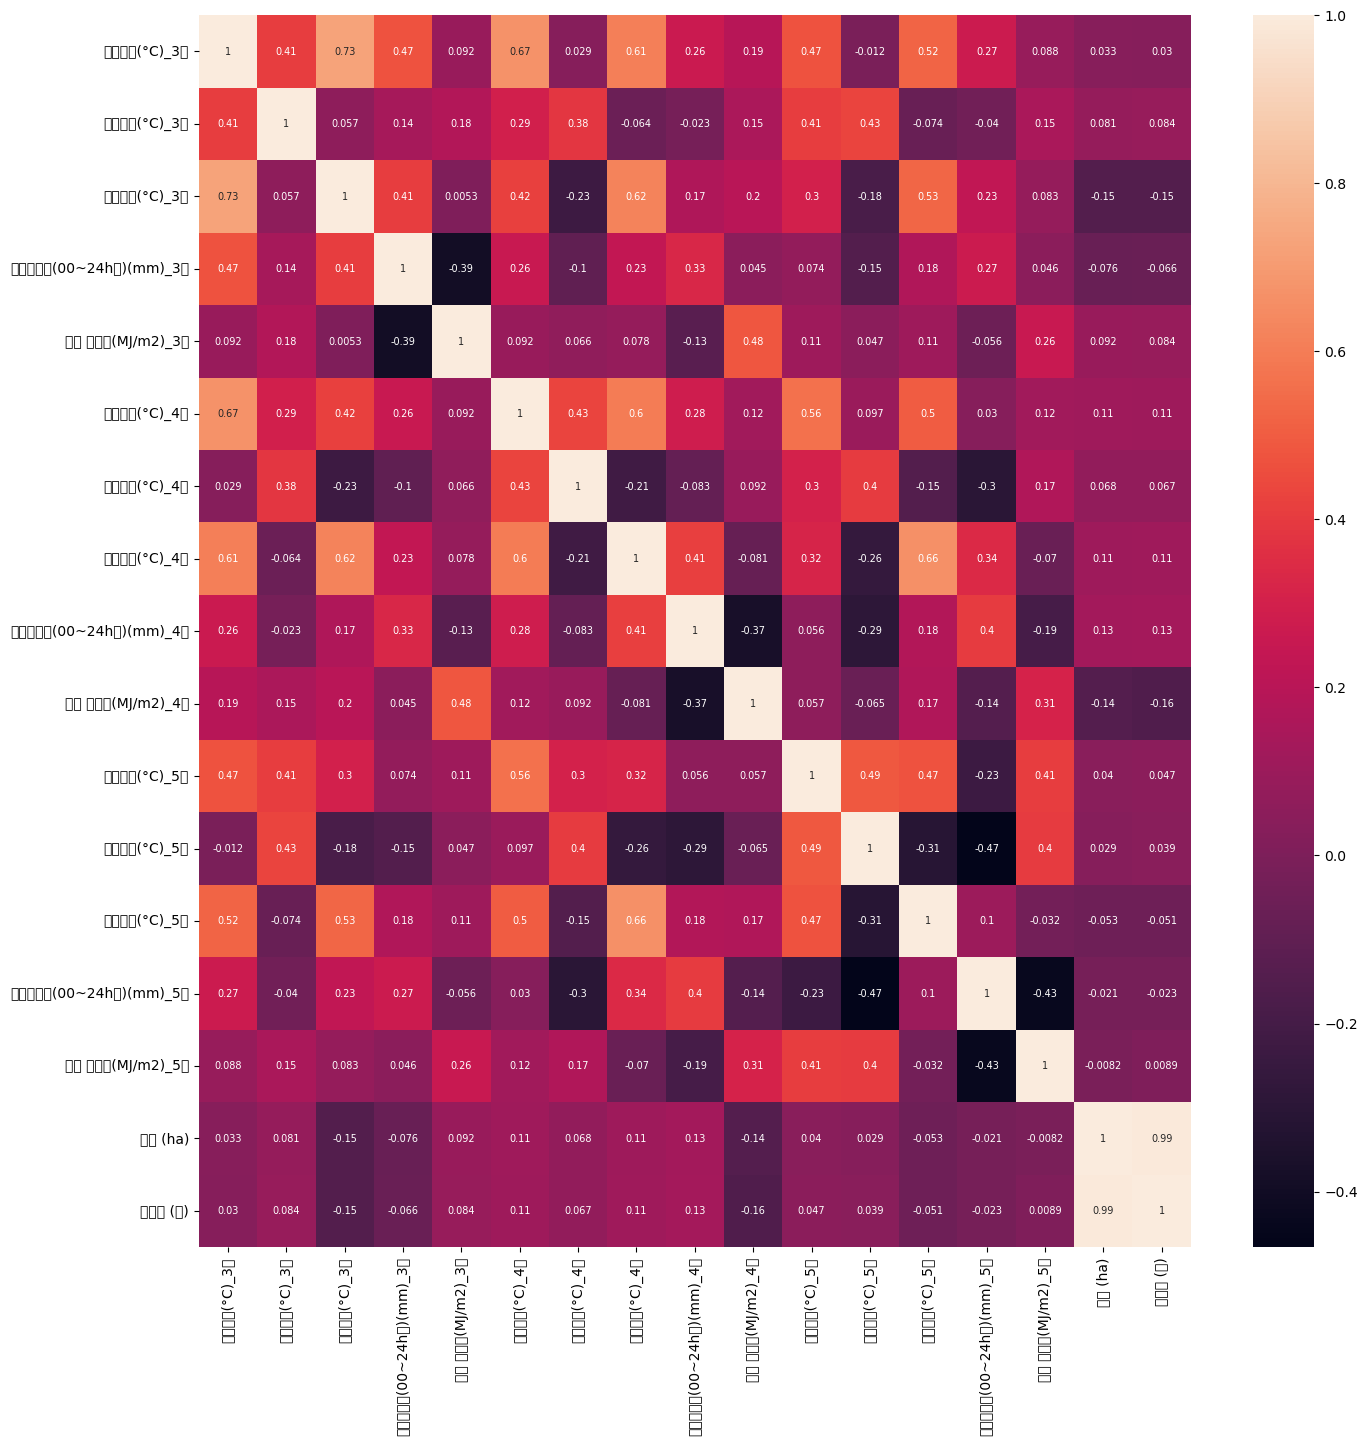

In [154]:
corr = np.corrcoef(df_spring.values.T)
fig = plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar=True, annot=True, square=False, xticklabels=df_spring.columns, yticklabels=df_spring.columns, annot_kws={"size":7})

Lasso 모델을 이용한 생산량 예측

In [ ]:
# # 데이터셋을 정규화
# std_X = StandardScaler()
# std_y = StandardScaler()
# std.fit(df_spring)
# df_spring_std = std.transform(df_spring)

In [155]:
feature_spring = df_spring.iloc[:,:-1]
target_spring = df_spring.iloc[:,-1]
# feature_spring.info()
# target_spring.info()

In [156]:
# 데이터셋을 정규화
std_X = StandardScaler()
std_y = StandardScaler()
std_X.fit(feature_spring)
std_y.fit(target_spring.values.reshape(-1,1))

feature_spring = std_X.transform(feature_spring)
target_spring = std_y.transform(target_spring.values.reshape(-1,1))

In [157]:
# 학습셋과 테스트셋을 분리
X_train, X_test, y_train, y_test = train_test_split(feature_spring, target_spring, test_size=0.2, random_state=19)

In [158]:
lasso = Lasso(alpha=0.1, max_iter=500)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))


rmse : 0.20801818363387078
R2 score : 0.9591796101161986


In [ ]:
# KFold를 이용한 교차 검증도 고려해 보고 싶음

In [ ]:
std_y.inverse_transform(y_pred.reshape(-1,1))

In [159]:
feature_summer = df_summer.iloc[:,:-1]
target_summer = df_summer.iloc[:,-1]

std_X_summer = StandardScaler()
std_y_summer = StandardScaler()
std_X_summer.fit(feature_summer)
std_y_summer.fit(target_summer.values.reshape(-1,1))

feature_summer = std_X_summer.transform(feature_summer)
target_summer = std_y_summer.transform(target_summer.values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(feature_summer, target_summer, test_size=0.2, random_state=19)

lasso_summer = Lasso(alpha=0.1, max_iter=500)
lasso_summer.fit(X_train, y_train)
y_pred = lasso_summer.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.22415304387153395
R2 score : 0.9687747370304819


In [ ]:
lasso_winter.coef_

In [ ]:
plt.plot(range(len(y_test)),std_y_summer.inverse_transform(y_test))
plt.plot(range(len(y_pred)),std_y_summer.inverse_transform(y_pred.reshape(-1,1)))


In [160]:
feature_fall = df_fall.iloc[:,:-1]
target_fall = df_fall.iloc[:,-1]

std_X_fall = StandardScaler()
std_y_fall = StandardScaler()
std_X_fall.fit(feature_fall)
std_y_fall.fit(target_fall.values.reshape(-1,1))

feature_fall = std_X_fall.transform(feature_fall)
target_fall = std_y_fall.transform(target_fall.values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(feature_fall, target_fall, test_size=0.2, random_state=19)

lasso_fall = Lasso(alpha=0.1, max_iter=500)
lasso_fall.fit(X_train, y_train)
y_pred = lasso_fall.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.2451919827186295
R2 score : 0.9470808674072897


In [161]:
feature_winter = df_winter.iloc[:,:-1]
target_winter = df_winter.iloc[:,-1]

std_X_winter = StandardScaler()
std_y_winter = StandardScaler()
std_X_winter.fit(feature_winter)
std_y_winter.fit(target_winter.values.reshape(-1,1))

feature_winter = std_X_winter.transform(feature_winter)
target_winter = std_y_winter.transform(target_winter.values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(feature_winter, target_winter, test_size=0.2, random_state=19)

lasso_winter = Lasso(alpha=0.1, max_iter=500)
lasso_winter.fit(X_train, y_train)
y_pred = lasso_winter.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.02429912915751831
R2 score : 0.889065300489937


In [162]:
X_train, X_test, y_train, y_test = train_test_split(feature_spring, target_spring, test_size=0.2, random_state=19)

rf_spring = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=19)
rf_spring.fit(X_train, y_train)
y_pred = rf_spring.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.15234357368175308
R2 score : 0.9781061152918745


In [163]:
X_train, X_test, y_train, y_test = train_test_split(feature_summer, target_summer, test_size=0.2, random_state=19)

rf_summer = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=19)
rf_summer.fit(X_train, y_train)
y_pred = rf_summer.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.2704887195432559
R2 score : 0.9545310276106976


In [ ]:
df_summer.iloc[:22]